# Demonstrates the calculation of VaR for a historical simulation

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from dotenv.main import load_dotenv
load_dotenv(override=True)

import os


In [16]:
def fetch_data_df():
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    return df

returns_df = fetch_data_df()
returns_df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-11,0.003231,0.006833,0.004578,-0.001342,-0.001916,-0.004075,0.000054
2005-10-12,-0.003550,-0.009657,-0.007867,-0.002606,-0.001570,-0.004370,0.000058
2005-10-13,-0.018599,-0.010692,0.000588,-0.002331,-0.003062,-0.003423,0.000058
2005-10-14,-0.007856,0.001569,-0.002991,-0.000564,0.000060,0.001618,0.000058
2005-10-17,-0.003613,0.000492,0.003290,0.000458,-0.000227,0.005447,0.000173


## Definig Parameters

In [17]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = assets_0 * float(os.getenv("FRAC_LIABILITIES"))
n_simulations = int(os.getenv("N_SIMULATIONS"))
n_days = int(os.getenv("N_DAYS"))

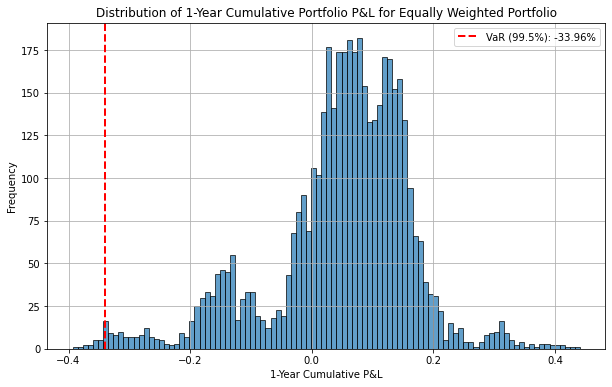

1-Year Value at Risk (95% confidence): -33.96%
Expected 1-Year Return: 4.87%
1-Year Standard Deviation: 11.62%


In [18]:
weights = np.full(returns_df.shape[1], 1 / returns_df.shape[1])

PnL_daily = (weights * returns_df.values).sum(axis=1)

rolling_window = 252  # Number of trading days in a year

# Calculate cumulative returns by summing over rolling windows
PnL_1yr_cumulative = pd.Series(PnL_daily).rolling(window=rolling_window).sum().dropna()

plt.figure(figsize=(10, 6))
plt.hist(PnL_1yr_cumulative, bins=100, edgecolor='black', alpha=0.7)
plt.title('Distribution of 1-Year Cumulative Portfolio P&L for Equally Weighted Portfolio')
plt.xlabel('1-Year Cumulative P&L')
plt.ylabel('Frequency')
plt.grid(True)

VaR_995_1yr = np.percentile(PnL_1yr_cumulative, 0.5)

# Add VaR line to the plot
plt.axvline(VaR_995_1yr, color='red', linestyle='dashed', linewidth=2, label=f'VaR (99.5%): {VaR_995_1yr:.2%}')
plt.legend()
plt.show()

# Step 6: Display VaR and other metrics
expected_return_1yr = np.mean(PnL_1yr_cumulative)
std_dev_1yr = np.std(PnL_1yr_cumulative)

print(f"1-Year Value at Risk (95% confidence): {VaR_995_1yr:.2%}")
print(f"Expected 1-Year Return: {expected_return_1yr:.2%}")
print(f"1-Year Standard Deviation: {std_dev_1yr:.2%}")


## $\Delta$ BOF Distribution

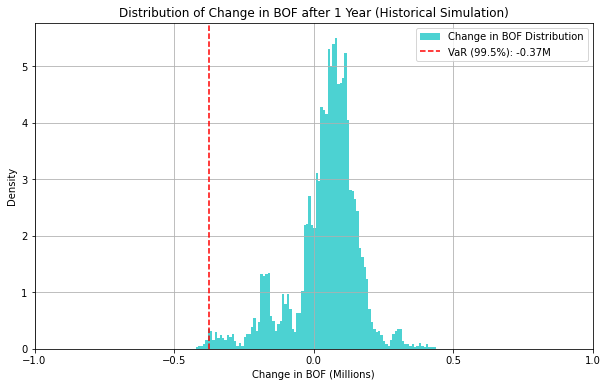

array([102595.56085443, 102220.60922023, 106498.36451588, ...,
       125093.62781603, 127551.89428672, 136337.5859592 ])

In [19]:
def plot_BOF_distribution_historical(): # ASSUMES EQUALLY WEIGHTED
    BOF_0 = assets_0 - liabilities_0  

    weights = np.full(returns_df.shape[1], 1 / returns_df.shape[1])

    PnL_portfolio_daily = (weights * returns_df.values).sum(axis=1)
    PnL_portfolio_1yr = pd.Series(PnL_portfolio_daily).rolling(window=252).sum().dropna()

    eonia_returns = returns_df.iloc[:, 6]  # EONIA daily returns
    PnL_eonia_1yr = eonia_returns.rolling(window=252).sum().dropna()

    # Align lengths of PnL_portfolio_1yr and PnL_eonia_1yr
    min_length = min(len(PnL_portfolio_1yr), len(PnL_eonia_1yr))
    PnL_portfolio_1yr = PnL_portfolio_1yr[-min_length:]
    PnL_eonia_1yr = PnL_eonia_1yr[-min_length:]

    assets_t1 = assets_0 * (1 + PnL_portfolio_1yr.values)
    liabilities_t1 = liabilities_0 * (1 + PnL_eonia_1yr.values)

    bof_t1 = assets_t1 - liabilities_t1
    bof_change = bof_t1 - BOF_0

    scr = np.percentile(bof_change, 100 * (1 - 0.995))

    plt.figure(figsize=(10, 6))
    plt.hist(bof_change / 1e6, bins=100, alpha=0.7, color='c', label='Change in BOF Distribution', density=True)
    plt.axvline(scr / 1e6, color='r', linestyle='--', label=f'VaR (99.5%): {scr / 1e6:.2f}M')
    plt.title('Distribution of Change in BOF after 1 Year (Historical Simulation)')
    plt.xlabel('Change in BOF (Millions)')
    plt.ylabel('Density')

    plt.xlim(-1, 1)
    plt.xticks(np.arange(-1, 1.1, 0.5))  # Increments of 0.5 within the range [-1, 1]

    plt.legend()
    plt.grid(True)
    plt.show()

    return bof_change

plot_BOF_distribution_historical()